## Loss curve

Read the log and plot the Loss.

In [1]:
import matplotlib.pyplot as plt

def load_loss(file:str):
    total_loss = []
    seq2seq_loss = []
    tree_loss = []
    with open(file, 'r', encoding='utf-8') as f:
        line = f.readline()
        while line:
            if line.find("Total loss") != -1:
                total_loss.append(float(line.split()[-1]))
            elif line.find("Tree loss") != -1:
                tree_loss.append(float(line.split()[-1]))
            elif line.find("Seq2Seq loss") != -1:
                seq2seq_loss.append(float(line.split()[-1]))
            line = f.readline()
    return seq2seq_loss, tree_loss, total_loss

def draw(ls:list, label, start_x=0):
    fig, ax = plt.subplots(figsize=(12,7))
    if len(ls)!=len(label):
        print("The number of tags and data does not match！")
    for i in range(len(ls)):
        ax.plot(ls[i], label=label[i])
    ax.set_xlim((start_x-5, len(ls[0])))
    ax.set_ylim((0,0.5))
    ax.set_title("Model Loss", fontdict={"fontsize":25})
    ax.set_xlabel("epoch")
    ax.set_ylabel("loss")
    ax.legend(loc="best")

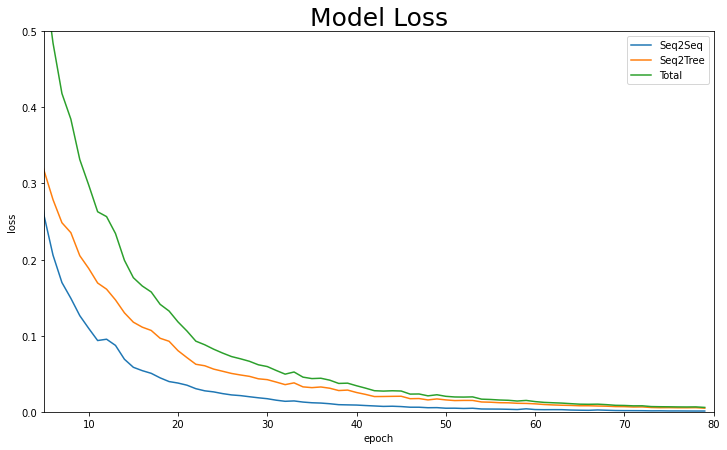

In [2]:
labels = ["Seq2Seq","Seq2Tree","Total"]
seq, tree ,total = load_loss("./log/B2B-Tree_num&att.log")
loss = [seq, tree ,total]
draw(loss, labels, 10)

## Operator statistics

In [13]:
import re
from typing import Dict

OP_LIST = ["+", "-", "*", "/", "^"]

def operator_statistics(res:str, acc:bool, operator_count:Dict, operator_acc:Dict):
    res = res.strip().lower()
    res = re.sub("[\]\}]", ")", re.sub("[\[\{]", "(", res))
    exp = res.strip().split()

    op_count = 0
    for e in exp:
        if e in OP_LIST:
            op_count += 1
    
    if str(op_count) not in operator_count:
        operator_count[str(op_count)] = 0
        operator_acc[str(op_count)] = 0
    
    if acc:
        operator_count[str(op_count)] += 1
        operator_acc[str(op_count)] += 1
    else:
        operator_count[str(op_count)] += 1

def operator_statistics(res:list, acc:bool, max_index:int, operator_count:Dict, operator_acc:Dict):
    exp = res

    op_count = 0
    for e in exp:
        if e < max_index:
            op_count += 1
    
    if str(op_count) not in operator_count:
        operator_count[str(op_count)] = 0
        operator_acc[str(op_count)] = 0
    
    if acc:
        operator_count[str(op_count)] += 1
        operator_acc[str(op_count)] += 1
    else:
        operator_count[str(op_count)] += 1

## Seq2Seq

The model was trained with infix and prefix expressions.

In [18]:
import time
import torch
from transformers import BertTokenizer
from src.utils import read_data_and_target_attributes, prepare_vail_test_attributes, compare_result, time_since

USE_CUDA = torch.cuda.is_available()

test_batch_size = 8

model = torch.load('models/seq2seq/model.pth')
tokenizer = BertTokenizer.from_pretrained('models/seq2seq/')

data_test, test_num_dicts = read_data_and_target_attributes('data/math23k/infix_math23k_processed.test', 'data/math23k/attributes.test', train=False, origin_path='data/test23k_processed.json')
test_target_batches, test_numdict_batches, test_encode_batches, test_nums_pos_batches, test_attributes_pos_batches = prepare_vail_test_attributes(data_test, test_num_dicts, tokenizer, test_batch_size=test_batch_size) 

if USE_CUDA:
    model.cuda()

model.eval()

start_time = time.time()
total = 0
exp_ac = 0
value_ac = 0
seq_operator_count = {}
seq_operator_acc = {}


for idx,target_batch in enumerate(test_target_batches):
    if USE_CUDA:
        test_output = model.generate(test_encode_batches[idx].input_ids.cuda(), attention_mask=test_encode_batches[idx].attention_mask.cuda(), num_pos_ids=test_nums_pos_batches[idx].cuda(), attribute_pos_ids=test_attributes_pos_batches[idx].cuda(), max_new_tokens=128, num_beams=5, num_return_sequences=1)
    else:
        test_output = model.generate(test_encode_batches[idx].input_ids.cpu(), attention_mask=test_encode_batches[idx].attention_mask, num_pos_ids=test_nums_pos_batches[idx], attribute_pos_ids=test_attributes_pos_batches[idx], max_new_tokens=128, num_beams=5, num_return_sequences=1)
            
    test_output = tokenizer.batch_decode(test_output, skip_special_tokens=True)
            
    for i,target in enumerate(target_batch):
        exp_bool, value_bool = compare_result(test_output[i], target, test_numdict_batches[idx][i])
        if exp_bool:
            exp_ac += 1
            value_ac += 1
        elif value_bool:
            value_ac += 1
        total += 1
        operator_statistics(target, value_bool, seq_operator_count, seq_operator_acc)

print(exp_ac, value_ac, total)
print("test_answer_acc", float(exp_ac) / total, float(value_ac) / total)
print("testing time", time_since(time.time() - start_time))
print("------------------------------------------------------")

seq_operator = {}
for key,item in seq_operator_count.items():
    seq_operator[key] = seq_operator_acc[key]/item

seq_operator_count = dict(sorted(seq_operator_count.items(), key=lambda x: x[0]))
seq_operator_acc = dict(sorted(seq_operator_acc.items(), key=lambda x: x[0]))
seq_operator = dict(sorted(seq_operator.items(), key=lambda x: x[0]))

print(seq_operator_count)
print(seq_operator_acc)
print(seq_operator)


755 832 1000
test_answer_acc 0.755 0.832
testing time 0h 12m 35s
------------------------------------------------------
{'1': 173, '2': 522, '3': 191, '5': 34, '4': 66, '7': 3, '6': 9, '0': 1, '9': 1}
{'1': 156, '2': 462, '3': 139, '5': 21, '4': 44, '7': 1, '6': 7, '0': 1, '9': 1}
{'1': 0.9017341040462428, '2': 0.8850574712643678, '3': 0.7277486910994765, '5': 0.6176470588235294, '4': 0.6666666666666666, '7': 0.3333333333333333, '6': 0.7777777777777778, '0': 1.0, '9': 1.0}


In [24]:
operator_count = {'1': 173, '2': 522, '3': 191, '5': 34, '4': 66, '7': 3, '6': 9, '0': 1, '9': 1}
operator_acc = {'1': 156, '2': 462, '3': 139, '5': 21, '4': 44, '7': 1, '6': 7, '0': 1, '9': 1}
operator = {'1': 0.9017341040462428, '2': 0.8850574712643678, '3': 0.7277486910994765, '5': 0.6176470588235294, '4': 0.6666666666666666, '7': 0.3333333333333333, '6': 0.7777777777777778, '0': 1.0, '9': 1.0}


print(operator_count)
print(operator_acc)
print(operator)

{'0': 1, '1': 173, '2': 522, '3': 191, '4': 66, '5': 34, '6': 9, '7': 3, '9': 1}
{'0': 1, '1': 156, '2': 462, '3': 139, '4': 44, '5': 21, '6': 7, '7': 1, '9': 1}
{'0': 1.0, '1': 0.9017341040462428, '2': 0.8850574712643678, '3': 0.7277486910994765, '4': 0.6666666666666666, '5': 0.6176470588235294, '6': 0.7777777777777778, '7': 0.3333333333333333, '9': 1.0}


## Tree-based Model

In [15]:
# coding: utf-8
import time
import torch
import torch.optim
from transformers import BertTokenizer
from src.EnhanceBertModel import EnhanceBertModel
from src.tree_train_and_evaluate import evaluate_tree
from src.train_and_evaluate import USE_CUDA, compute_prefix_tree_result
from src.tree_models import Prediction, GenerateNode, Merge
from src.expressions_transfer import from_infix_to_prefix
from src.utils import time_since, read_json , load_raw_data, load_attributes
from src.pre_data import transfer_num, prepare_data

embedding_size = 128
hidden_size = 768
beam_size = 5
ori_path = './data/'
prefix = '23k_processed.json'

def get_train_test_fold(ori_path, prefix,data, pairs, attributes):
    mode_train = 'train'
    mode_valid = 'valid'
    mode_test = 'test'
    train_path = ori_path + mode_train + prefix
    valid_path = ori_path + mode_valid + prefix
    test_path = ori_path + mode_test + prefix
    train = read_json(train_path)
    train_id = [item['id'] for item in train]
    valid = read_json(valid_path)
    valid_id = [item['id'] for item in valid]
    test = read_json(test_path)
    test_id = [item['id'] for item in test]
    train_fold = []
    valid_fold = []
    test_fold = []

    for item,pair,attr in zip(data, pairs, attributes):
        pair = list(pair)
        pair.append(attr)
        pair = tuple(pair)
        if item['id'] in train_id:
            train_fold.append(pair)
        elif item['id'] in test_id:
            test_fold.append(pair)
        else:
            valid_fold.append(pair)
    return train_fold, test_fold, valid_fold

data = load_raw_data("data/Math_23K.json")
attributes = load_attributes('data/Math_23K_attributes.json')

pairs, generate_nums, copy_nums = transfer_num(data)

temp_pairs = []
for p in pairs:
    temp_pairs.append((p[0], from_infix_to_prefix(p[1]), p[2], p[3], p[1]))

pairs = temp_pairs

train_fold, test_fold, valid_fold = get_train_test_fold(ori_path, prefix, data, pairs,attributes)

pairs_tested = test_fold
pairs_trained = train_fold

tokenizer = BertTokenizer.from_pretrained('models/tree/')

output_lang, train_pairs, test_pairs = prepare_data(pairs_trained, pairs_tested, generate_nums, copy_nums, tokenizer)

# Initialize models
encoder = EnhanceBertModel.from_pretrained('models/tree/')

predict = Prediction(hidden_size=hidden_size, op_nums=output_lang.n_words - copy_nums - 1 - len(generate_nums),
                     input_size=len(generate_nums))
generate = GenerateNode(hidden_size=hidden_size, op_nums=output_lang.n_words - copy_nums - 1 - len(generate_nums),
                        embedding_size=embedding_size)
merge = Merge(hidden_size=hidden_size, embedding_size=embedding_size)

predict.load_state_dict(torch.load('models/tree/predict.pth'))
generate.load_state_dict(torch.load('models/tree/generate.pth'))
merge.load_state_dict(torch.load('models/tree/merge.pth'))

# Move models to GPU
if USE_CUDA:
    encoder.cuda()
    predict.cuda()
    generate.cuda()
    merge.cuda()

generate_num_ids = []
for num in generate_nums:
    generate_num_ids.append(output_lang.word2index[num])

value_ac = 0
equation_ac = 0
eval_total = 0
tree_operator_count = {}
tree_operator_acc = {}

max_index = output_lang.num_start

start = time.time()
for test_batch in test_pairs:
    test_res = evaluate_tree(test_batch[0], test_batch[1], generate_num_ids, encoder, predict, generate,
                                     merge, output_lang, test_batch[5], test_batch[7], beam_size=beam_size)
    val_ac, equ_ac, _, _ = compute_prefix_tree_result(test_res, test_batch[2], output_lang, test_batch[4], test_batch[6])
    if val_ac:
        value_ac += 1
    if equ_ac:
        equation_ac += 1
    eval_total += 1
    operator_statistics(test_batch[2], val_ac, max_index, tree_operator_count, tree_operator_acc)
print(equation_ac, value_ac, eval_total)
print("test_answer_acc", float(equation_ac) / eval_total, float(value_ac) / eval_total)
print("testing time", time_since(time.time() - start))
print("------------------------------------------------------")

tree_operator = {}
for key,item in tree_operator_count.items():
    tree_operator[key] = tree_operator_acc[key]/item

tree_operator_count = dict(sorted(tree_operator_count.items(), key=lambda x: x[0]))
tree_operator_acc = dict(sorted(tree_operator_acc.items(), key=lambda x: x[0]))
tree_operator = dict(sorted(tree_operator.items(), key=lambda x: x[0]))

print(tree_operator_count)
print(tree_operator_acc)
print(tree_operator)

Reading lines...
Transfer numbers...
Indexing words...
Indexed 23 words in output
Number of training data 21162
Number of testind data 1000
717 851 1000
test_answer_acc 0.717 0.851
testing time 0h 1m 51s
------------------------------------------------------
{'0': 1, '1': 173, '2': 522, '3': 191, '4': 66, '5': 34, '6': 9, '7': 3, '9': 1}
{'0': 1, '1': 157, '2': 470, '3': 151, '4': 43, '5': 21, '6': 6, '7': 1, '9': 1}
{'0': 1.0, '1': 0.9075144508670521, '2': 0.9003831417624522, '3': 0.7905759162303665, '4': 0.6515151515151515, '5': 0.6176470588235294, '6': 0.6666666666666666, '7': 0.3333333333333333, '9': 1.0}


## BERT2BERT-Tree Model

In [17]:
# coding: utf-8
import time
import torch.optim
from src.tree_models import Prediction, GenerateNode, Merge
from src.train_and_evaluate import evaluate_tree, compute_prefix_tree_result
from src.expressions_transfer import from_infix_to_prefix
from src.pre_data import transfer_num, prepare_data
from src.utils import read_json, load_raw_data, load_attributes


embedding_size = 128
hidden_size = 768
beam_size = 5
ori_path = './data/'
prefix = '23k_processed.json'

def get_train_test_fold(ori_path,prefix,data,pairs,attributes):
    mode_train = 'train'
    mode_valid = 'valid'
    mode_test = 'test'
    train_path = ori_path + mode_train + prefix
    valid_path = ori_path + mode_valid + prefix
    test_path = ori_path + mode_test + prefix
    train = read_json(train_path)
    train_id = [item['id'] for item in train]
    valid = read_json(valid_path)
    valid_id = [item['id'] for item in valid]
    test = read_json(test_path)
    test_id = [item['id'] for item in test]
    train_fold = []
    valid_fold = []
    test_fold = []

    for item,pair,attr in zip(data, pairs, attributes):
        pair = list(pair)
        pair.append(attr)
        pair = tuple(pair)
        if item['id'] in train_id:
            train_fold.append(pair)
        elif item['id'] in test_id:
            test_fold.append(pair)
        else:
            valid_fold.append(pair)
    return train_fold, test_fold, valid_fold

data = load_raw_data("data/Math_23K.json")
attributes = load_attributes('data/Math_23K_attributes.json')

pairs, generate_nums, copy_nums = transfer_num(data)

temp_pairs = []
for p in pairs:
    temp_pairs.append((p[0], from_infix_to_prefix(p[1]), p[2], p[3], p[1]))

pairs = temp_pairs

train_fold, test_fold, valid_fold = get_train_test_fold(ori_path,prefix,data,pairs,attributes)

pairs_tested = test_fold
pairs_trained = train_fold

tokenizer = BertTokenizer.from_pretrained('models/b2b-tree-attributes/')

output_lang, train_pairs, test_pairs = prepare_data(pairs_trained, pairs_tested, generate_nums, copy_nums, tokenizer)

model = torch.load('models/b2b-tree-attributes/model.pth')

predict = Prediction(hidden_size=hidden_size, op_nums=output_lang.n_words - copy_nums - 1 - len(generate_nums),
                     input_size=len(generate_nums))
generate = GenerateNode(hidden_size=hidden_size, op_nums=output_lang.n_words - copy_nums - 1 - len(generate_nums),
                        embedding_size=embedding_size)
merge = Merge(hidden_size=hidden_size, embedding_size=embedding_size)

predict.load_state_dict(torch.load('models/b2b-tree-attributes/predict.pth'))
generate.load_state_dict(torch.load('models/b2b-tree-attributes/generate.pth'))
merge.load_state_dict(torch.load('models/b2b-tree-attributes/merge.pth'))

# Move models to GPU
if USE_CUDA:
    model.cuda()
    predict.cuda()
    generate.cuda()
    merge.cuda()

generate_num_ids = []
for num in generate_nums:
    generate_num_ids.append(output_lang.word2index[num])

value_ac = 0
equation_ac = 0
eval_total = 0
model_operator_count = {}
model_operator_acc = {}

max_index = output_lang.num_start

start = time.time()
for test_batch in test_pairs:
    test_res = evaluate_tree(test_batch[0], test_batch[1], generate_num_ids, model, predict, generate,
                                     merge, output_lang, test_batch[5], test_batch[7], beam_size=beam_size)
    val_ac, equ_ac, _, tar = compute_prefix_tree_result(test_res, test_batch[2], output_lang, test_batch[4], test_batch[6])
    if val_ac:
        value_ac += 1
    if equ_ac:
        equation_ac += 1
    eval_total += 1
    operator_statistics(test_batch[2], val_ac, max_index, model_operator_count, model_operator_acc)
print(equation_ac, value_ac, eval_total)
print("test_answer_acc", float(equation_ac) / eval_total, float(value_ac) / eval_total)
print("testing time", time_since(time.time() - start))
print("------------------------------------------------------")

model_operator = {}
for key,item in model_operator_count.items():
    model_operator[key] = model_operator_acc[key]/item

model_operator_count = dict(sorted(model_operator_count.items(), key=lambda x: x[0]))
model_operator_acc = dict(sorted(model_operator_acc.items(), key=lambda x: x[0]))
model_operator = dict(sorted(model_operator.items(), key=lambda x: x[0]))

print(model_operator_count)
print(model_operator_acc)
print(model_operator)

Reading lines...
Transfer numbers...
Indexing words...
Indexed 23 words in output
Number of training data 21162
Number of testind data 1000
732 859 1000
test_answer_acc 0.732 0.859
testing time 0h 1m 54s
------------------------------------------------------
{'0': 1, '1': 173, '2': 522, '3': 191, '4': 66, '5': 34, '6': 9, '7': 3, '9': 1}
{'0': 1, '1': 157, '2': 474, '3': 154, '4': 40, '5': 22, '6': 8, '7': 2, '9': 1}
{'0': 1.0, '1': 0.9075144508670521, '2': 0.9080459770114943, '3': 0.806282722513089, '4': 0.6060606060606061, '5': 0.6470588235294118, '6': 0.8888888888888888, '7': 0.6666666666666666, '9': 1.0}
